# A Python Light Meter Client

## Introduction

This is a different style of blog post from that which I normally post here.  Usually I explain a Python technique by weaving the explanation and executable code in a single Jupter Notebook.  In this post, I'm going to sort-of-embed a variety of code snippets in one post.

## Arduino and Python

I was having a cleanup, and discovered a number of Ardunino kits that I had put away, when my study/workshop was re-purposed as a Grand-daughter's bedroom.  What with lockdown and all, I wondered what I might do with them.

I decided to make a prototype of a design, where the Arduino acted as a smart peripheral for a laptop.  In the process, I didn't learn much more about  the Arduino, but I did learn about some useful Python libraries.

----
## Light Sensor Design

So the basic idea was to have an Arduino to read a light sensor, and drive a LCD display, to be self-contained. Additionally, the Arduino would write the light level up a serial cable, to be read by a Python application on the Windows laptop.  The Windows Python application would then display the light level in decimal form, and as a meter bar. 

### Hardware Design

The diagram below show the breadboard prototype.

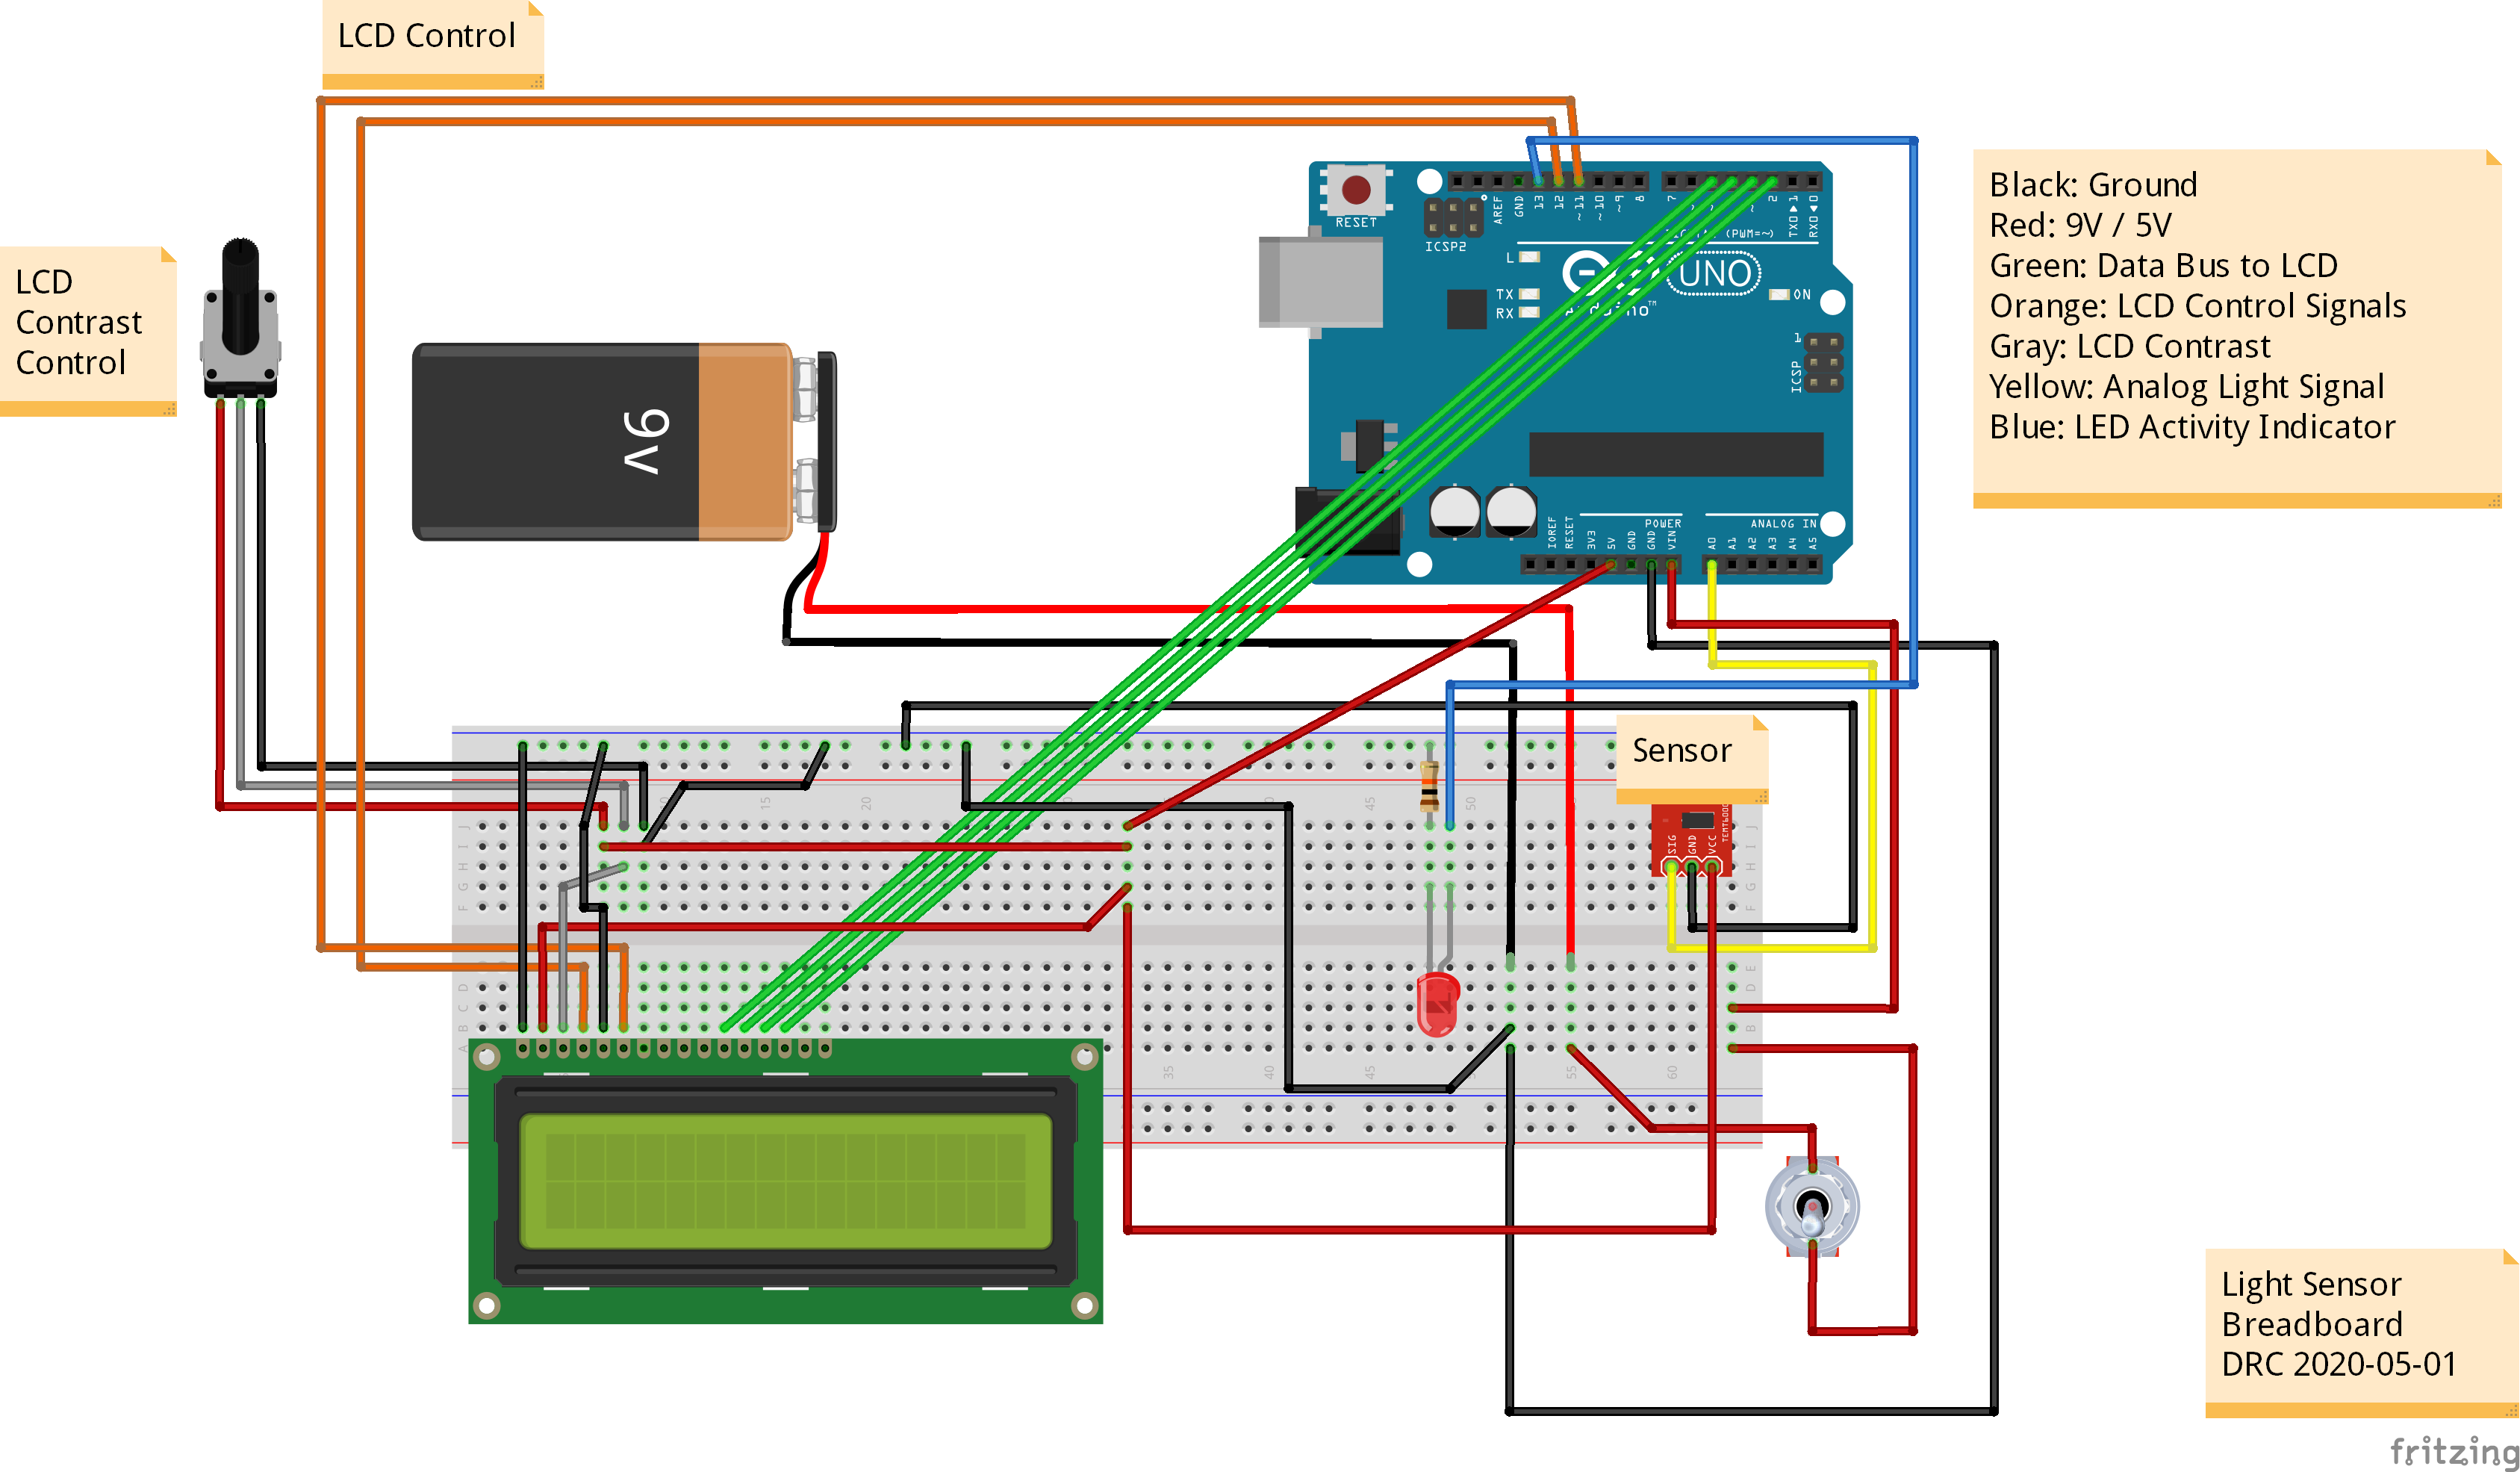

In [6]:
from IPython.display import Image
Image("images/LightSensor_bb.png")

The diagram shows the prototype being powered by a 9V battery, but in actual practice it was really powered by the USB cable from the laptop.  However, in fallback mode, with no laptop connection, the prototype could be run off the battery, and display via the 16 x 2 LCD display.

If I was to really run off a 9V battery for any length of time, I would have to investigate the low power features of the Arduino (which is on my TODO list).  I only sample the light levels about every half second, and should really sleep between these bursts of activity.

The solitary RED LED is blinked every time I read from the light sensor, just to show that something is happening.

The 16 x 2 LCD display  was really bare-bones, with no backlighting.  I used a 4 bit data bus to drive the display.

### Bill of Material

A bill of material is automatically produced by Fritzing, as a by-product of drawing the breaddboard layout above

In [12]:
from IPython.display import IFrame
IFrame(src='images/LightSensor_bom.html', width=700, height=600)

----

### Software Design


The Ardunio sketch is shown below:


```
/*
  Display Light Levels on LCD Display
  
  This example code is in the public domain.
 */
 
 #include <LiquidCrystal.h>
 
 LiquidCrystal lcd(12,11,5,4,3,2);
 
 // 12 -> D/I Select
 // 11 -> Signal Enable
 
 // 5,3,4,2 -> Data Bus Line

 int updateDelay = 1000;  // update display every second
 
 int lightLevel;  // hold light level read from sensor
 int blinkLed = 8; // Pin used to blink LED when light level read
 int blinkDelay = 100; // period of time Blinking LED is on after light level read
 
 
// the setup routine runs once when you press reset:
void setup() {                
  // initialize the digital pins as an output.
  lcd.begin(16, 2);
  lcd.print("Light Sensor");

  // initialize pin driving activity LED
  pinMode(blinkLed, OUTPUT);

  // initialize serial line
  Serial.begin(38400);

  // initialize serial comms line
  
} // end setup

// the loop routine runs over and over again forever:
void loop() {
  for (int i=1; i< 1000; i=i+1){
    
    // read light level
    lightLevel = analogRead(A0);
    // write to line two of LCD display
    lcd.begin(16, 2);
    lcd.print("Light Sensor");
    
    lcd.setCursor(0,1);
    lcd.print(lightLevel, DEC);
    
    // blink LED
    digitalWrite(blinkLed, HIGH);
    delay(blinkDelay);
    digitalWrite(blinkLed, LOW);

    // write light level value to serial line as ascii text
    Serial.println(lightLevel, DEC);
    
    // wait to update display again
    delay(updateDelay-blinkDelay);
  } // end for
} // end loop
```

The basic idea is simple.  In the "do-forever" loop, I read the sensor.  I then write to the LCD display.  I had to write both lines, as there didn't seem to be a clear-one-line operation; as a result I have to clear the LCD display each time through the loop.  Line one is just the text "Light Sensor", line two is the left justified sensor value.

I then blink the LED, to show I have updated the LCD display.

Next I write (at quite a high baud rate) to the serial line.  I was able to use the Arduino IDE Serial Line Monitor to check these values.

-----
## Laptop Application

For the laptop application, I have to build a GUI, read from a serial line (USB), update the GUI, and log the reading.  Thankfully there are two libraries to accomplish two of those tasks, ```PySimpleGUI``` and ```serial```

```
# pysimplegui build the Windows UI
import PySimpleGUI as sg      

# import serial comms package
import serial
import serial.tools.list_ports as list_ports

import time
import datetime

from pathlib import Path
```

We define a couple of helper functions

```
def show_ports():
    '''
    show_ports: show available ports for serial communications
    
    Parameters:
    None
    
    Returns:
    None
    
    Side Effects:
    prints to standard output, one line per port
    '''
    ports = list(list_ports.comports() )
    _ = [print(p) for p in ports]
    return None
    
#end show_ports
```

```
def setup_comms_port():
    '''
    setup_serial_port: Setup to read data from Arduino serial line
    
    This functiions sets up a serial communications port for 
    PC to Arduino communication.
    
    Note this function must align with the corresponding Arduino sketch
    especially wrt BaudRate
    
    The COM3 port is used (appears to be default port for USB serial lines)
    
    Parameters:
    None
    
    Returns
    SerialPort object
    
    Side Effects
    Set up port COM3 at fast baudrate, clears
    any input buffer.  We do the latter, so that
    the data read from Arduino is roughly in step with
    Arduino writes
    '''
    serialPort = serial.Serial(port="com3", baudrate=38400,)
    serialPort.reset_input_buffer()
    
    return serialPort
   ```

Every time we run the application, we log the readings to a unique file name

```
#
# get unique name for log file
#
LOGGING_PATH = '/ArduinoLogging/'
now = str(datetime.datetime.now())
now_name = now[0:10] + '-' + now[11:13] + now[14:16] + now[17:19] + '.csv'
print('Log File Name: ', now_name,)

log_path = Path(LOGGING_PATH + now_name)
if ( log_path.exists () ):
    pass
else:
    # create file if needed (should always be needed)
    f = log_path.open(mode='x')
    f.close()
#end if
```


The main loop is below:

Note we have two nested ```with``` clauses, one to close the serial port when finished, one to close the logging file.  On user exit, we close the GUI window manually.  In order to make sure we consume readings (and don't fall behind), we check the serial line at  twice the rate we write to it from the Arduino 

The logging file is an CSV format, so we can easily process it with ```pandas```


```
# screen check for CANCEL command period in  millisecs
# quit fast, so we can then read serial line with timout
SCREEN_READ_PERIOD = 50


#
# define GUI to show light levels
# bar is 100 (default font) chars wide, 200 pixels high

TEXT_FONT_SIZE = 100
BAR_PIXELS_HIGH = 200
BAR_CHARACTERS_WIDE = 100
PROGRESS_BAR_MAX = 1024

layout = [      [sg.Text('Light Meter', size=(12,1), font=("Helvetica", TEXT_FONT_SIZE))],     
                [sg.ProgressBar(PROGRESS_BAR_MAX, orientation='h', size=(BAR_CHARACTERS_WIDE, BAR_PIXELS_HIGH), key='pbar',)],
                [sg.Text(str(23), size=(5,1), font=("Helvetica", TEXT_FONT_SIZE), key='Light',)],      
                [sg.Cancel()]
         ]      

window = sg.Window('Light Meter', layout,)
progress_bar = window['pbar']

#
#  Set up Serial Port
show_ports()
#  serial_port = setup_comms_port()
with serial.Serial(port="com3", baudrate=38400,) as serial_port:
    serial_string = ''
    serial_port.reset_input_buffer()
    
    # open logging file with auto close
    with log_path.open(mode='a') as f:
        for i in range(1,1000000):
            # read status of GUI
            event, values = window.read(timeout=SCREEN_READ_PERIOD,)    

            # check for user exit
            if( event=='Cancel' or event is None):
                break
            #end if

            # read values from serial port, and show in screen
            if(serial_port.in_waiting > 0):

                serial_string = serial_port.readline()
                serial_string = serial_string.decode('ascii')

                light = int(serial_string)

                window['Light'].update(light )
                progress_bar.UpdateBar(light)
                
                # log new data
                f.write(str(datetime.datetime.now()) + ' , ' + str(light) + '\n')

            else:

                time.sleep(0.5)
            #end if

        #end for
    #end with
#end with
# with clause should close serial port for us
window.close()
```


The code snippet
```
layout = [      [sg.Text('Light Meter', size=(12,1), font=("Helvetica", TEXT_FONT_SIZE))],     
                [sg.ProgressBar(PROGRESS_BAR_MAX, orientation='h', size=(BAR_CHARACTERS_WIDE, BAR_PIXELS_HIGH), key='pbar',)],
                [sg.Text(str(23), size=(5,1), font=("Helvetica", TEXT_FONT_SIZE), key='Light',)],      
                [sg.Cancel()]
         ]      

window = sg.Window('Light Meter', layout,)
progress_bar = window['pbar']
```
produces the GUI as below

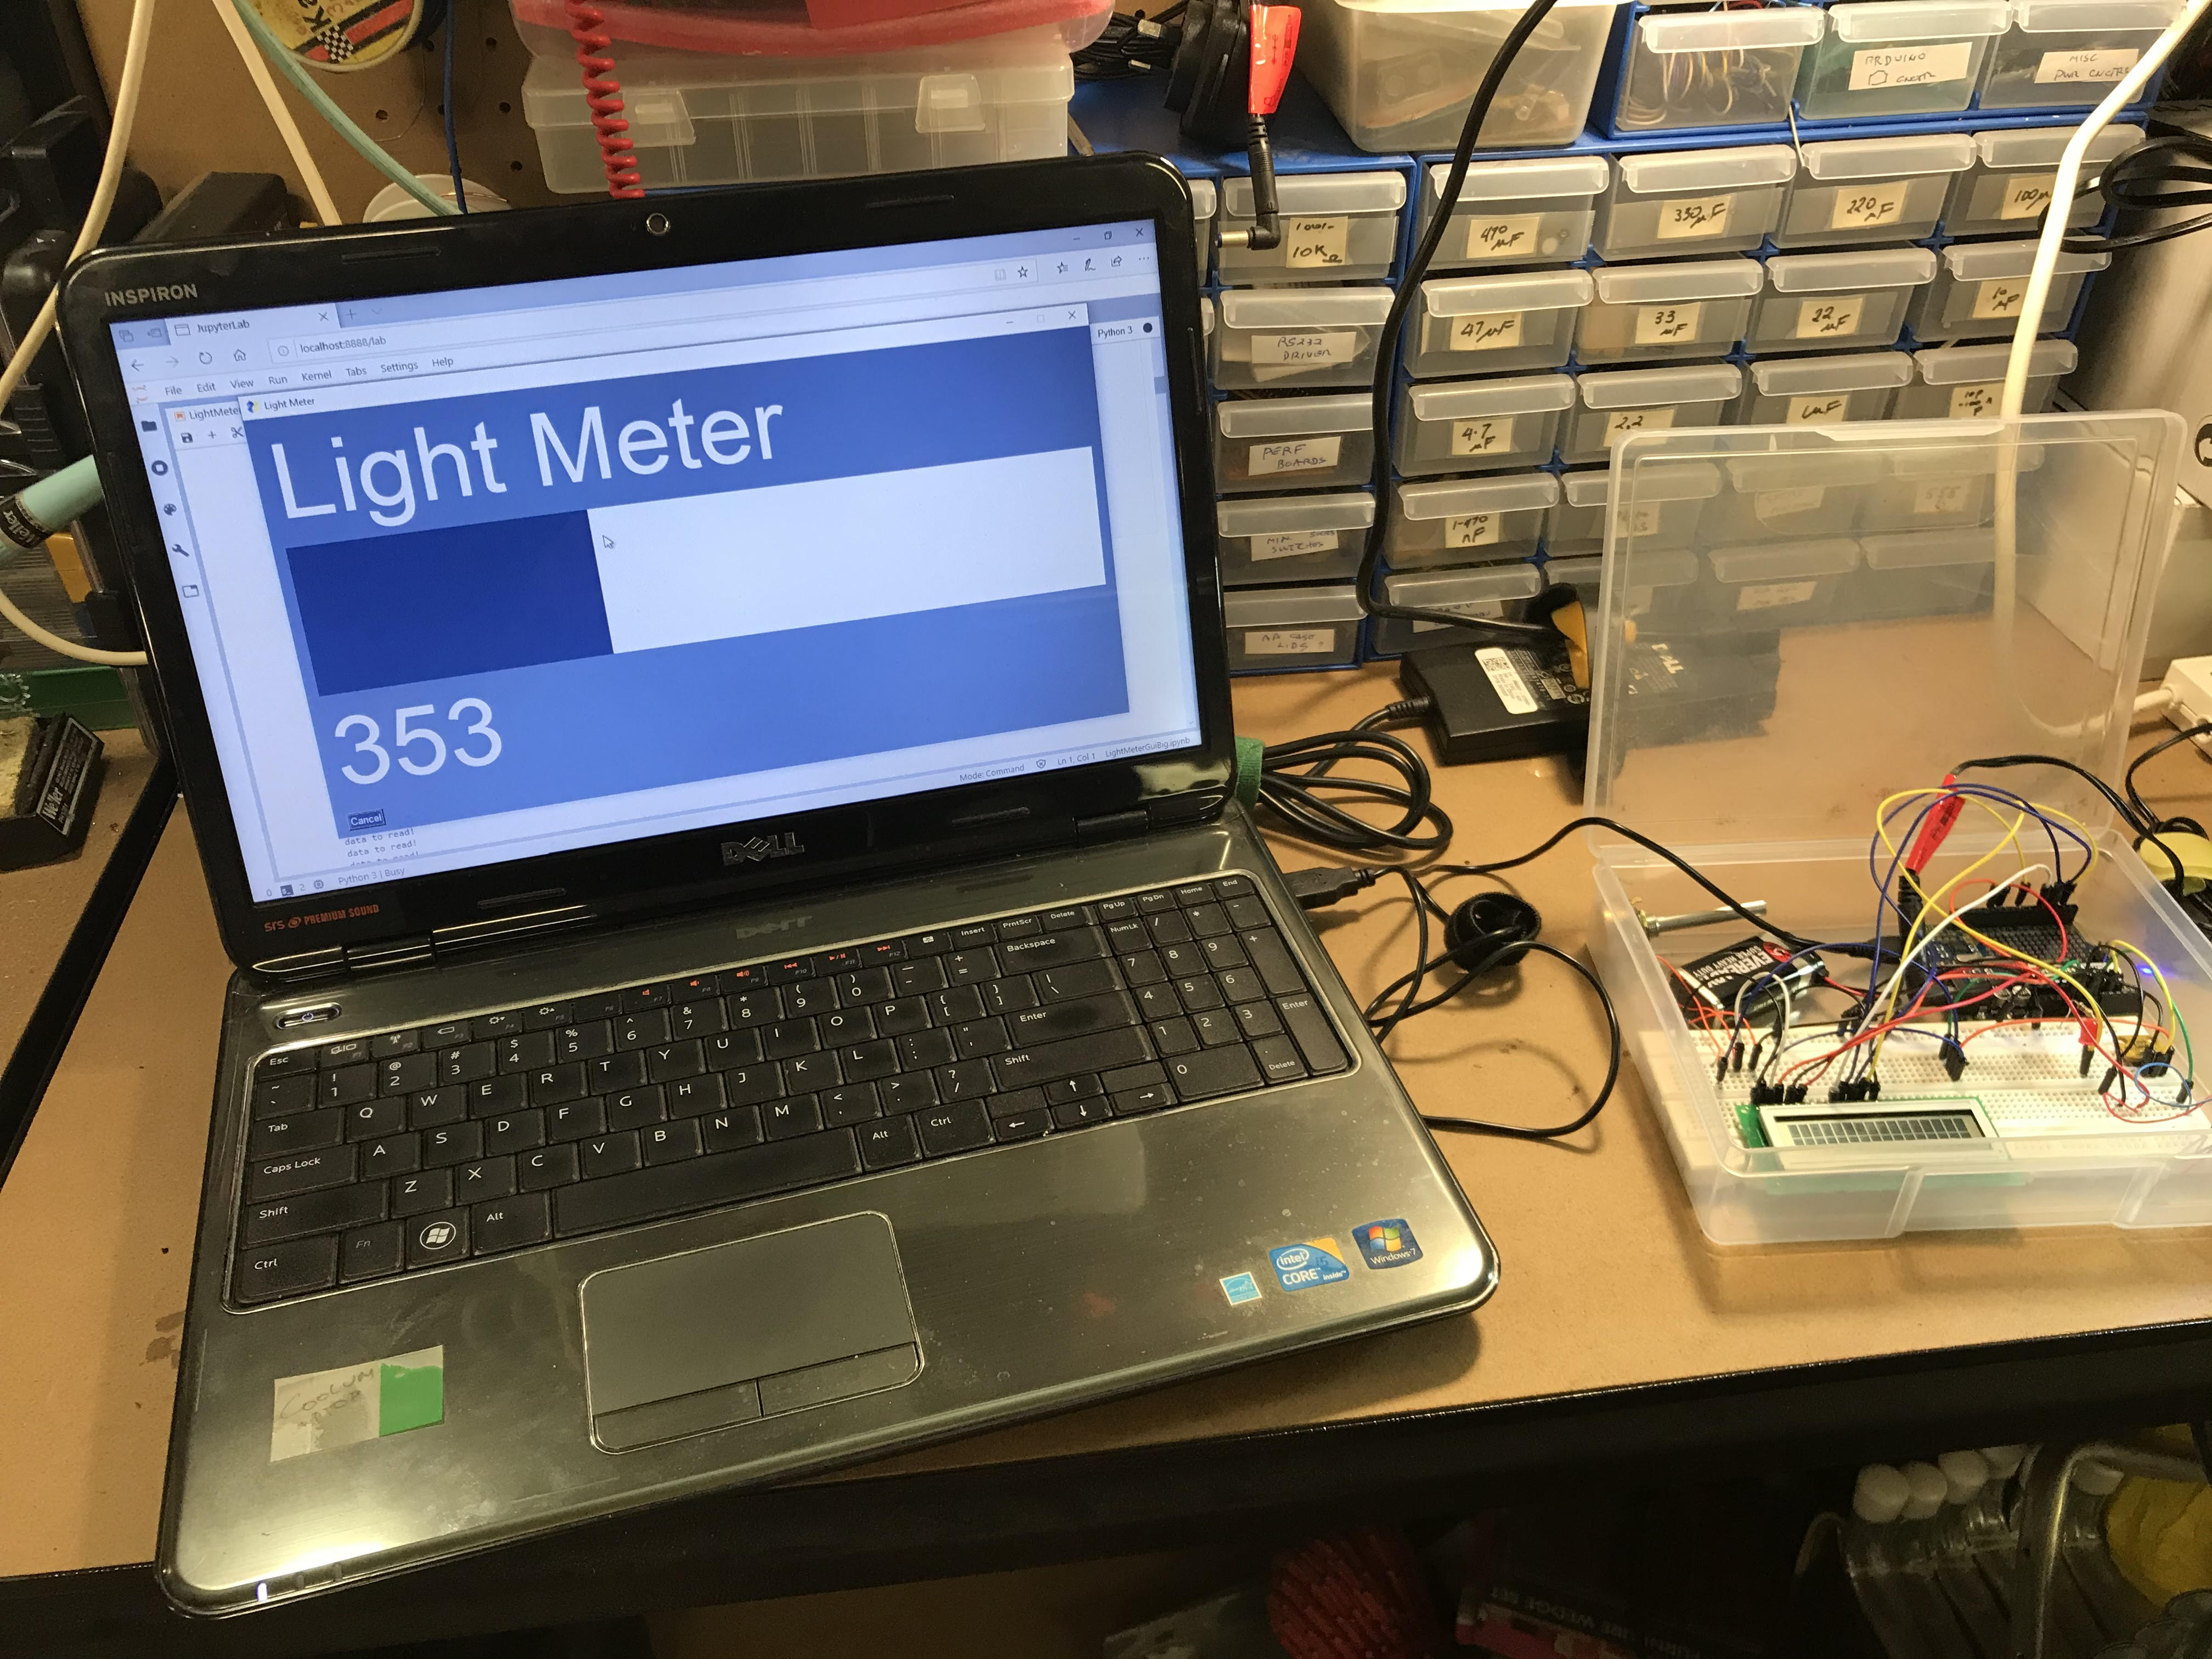

In [10]:
from IPython.display import Image
Image("images/setup.jpg")

I choose to clear the serial line buffer at  the start of the loop by:

```
serial_port.reset_input_buffer()
```
so that the values displayed on the LCD immediately match those on the laptop GUI.  The Arduino could be (and was, in my case) pumping data up the line long before the laptop application is started

### Laptop Setup

I wanted to collect a full 24 hours worth of light readings, so I had to configure my laptop not to shutdown 

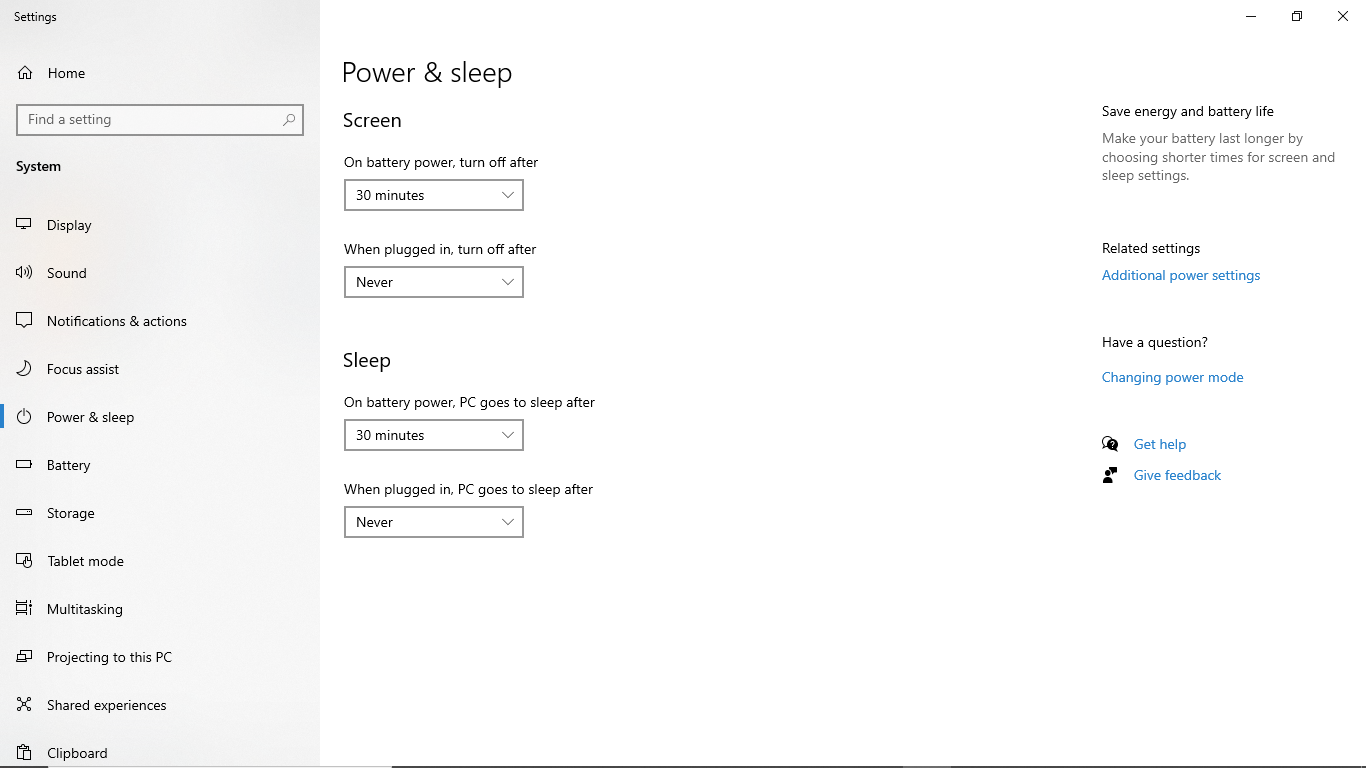

In [2]:
from IPython.display import Image
Image("images/PowerSettings.png")

----
## Display of Results

Displaying 24 hours of data involved reading the CSV file,  

```
data = pd.read_csv('/ArduinoLogging/2020-05-07-085450.csv',  names=['Time', 'Light'], )
```

converting the datetime strings to ```pandas``` datetime objects,

```
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%d %H:%M:%S.%f')
```

and plotting the results

```
fig, ax = plt.subplots( figsize=(10,8))

# just show hour minute in x axis labels
hfmt = dates.DateFormatter('%H:%M')

# we just want ticks and labels at every hour
ax.xaxis.set_major_locator(dates.HourLocator())
ax.xaxis.set_major_formatter(hfmt)

ax.set_xlabel('Time of Day')
ax.set_ylabel('Light Sensor Reading')

ax.set_title('Light Sensor Values', fontsize=40, )
ax.plot(data['Time'], data['Light'], label='Light Level',)

# create a grid and a legend at lower left
ax.legend(loc='lower left')
ax.grid(axis='both', which='major',)

# autofmt is OK but prefer x axis labels vertical
#fig.autofmt_xdate()

# prefer the x axis labels to be vertical
ax.tick_params(axis='x', labelrotation= 90) 
```


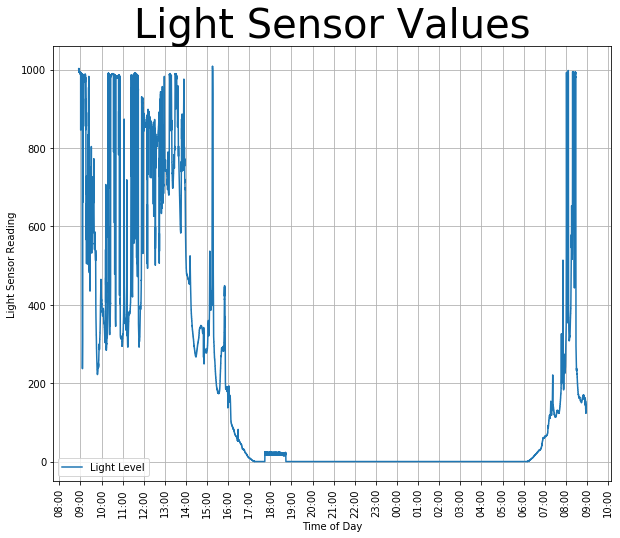

In [13]:
from IPython.display import Image
Image("images/lightreadings.png")

The day was one with overcast periods, and then full sun.  Human eye does a really good job of accomodating to different light levels, but my typical solar power readings shown below also exhibit the deep dips in light levels when the clouds turn up

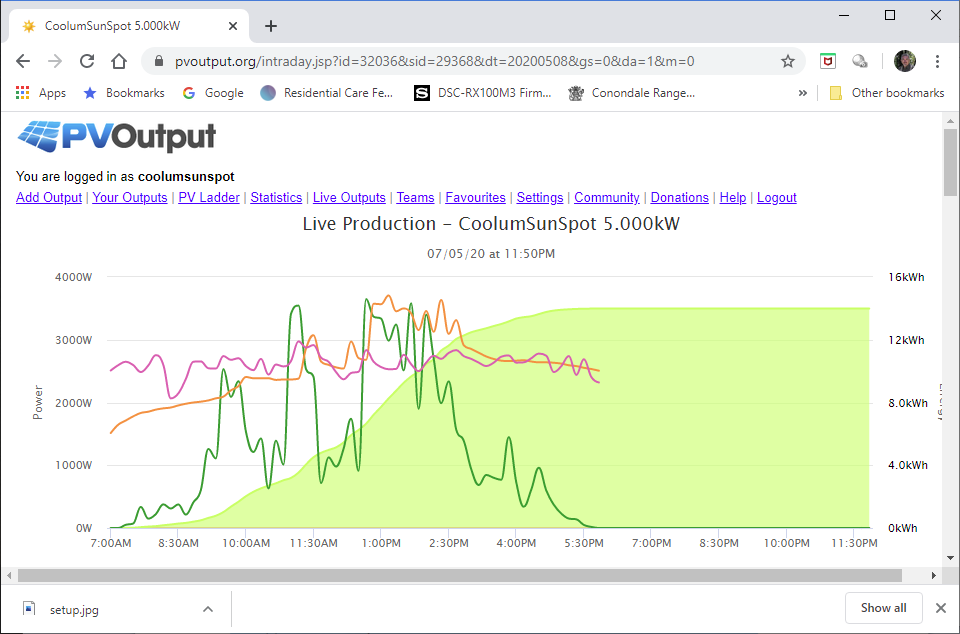

In [14]:
from IPython.display import Image
Image("images/solar.png")

-----
## Conclusion

The next stage of this prototyping might be to investigate a WiFi link to the laptop, and then to store store readings in a SD memory card, and regurgitate these to the laptop when triggered.  This is allow environmental sensors to be left unattended, with periodic hoovering of the data.   